In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DayLocator, DateFormatter, date2num

### Project Outline

This is a brief exercise in webscraping. I use BeautifulSoup to go through the reviews of a newly release indie horror movie, Midsommar, on a movie reviewing/social media platform, Letterboxd. I was initially interested in seeing how positive reviews from influential users prompt their followers to watch new releases. Ideally, this will be done through some kind of network time series. In the meantime, I collect information about the users that reviewed the movie and the date at which this was done. Luckily, Letterboxd has a diary feature which allows users to both review and log in the date at which they watched a certain movie. I then gather some user statistics that can be found on their home page (number of movies watched, number of followers, number of users following, etc) as well as parts of their network.

I then use the data for some exploratory analysis.

### Web Scraping

The code below gathers the information I described previously.

In [17]:
user_page = [] #empty results vector
date = []
rating = []
user_name = []
total_films =  []
films_2019 =  []
followers =  []
following =  []
ratio =  []
followers_list = []
following_list = []

#getting results for a specific movie
movie_tag = "midsommar"

url = "https://letterboxd.com/film/" + movie_tag + "/ratings/" #movie url
res = requests.get(url) #request data
soup = BeautifulSoup(res.text, "lxml") 
users = soup.select(".-a40")  #returns list with all users having rated movie

for i in range(1, len(users)): #for every user having rated midsommar, excluding 0 which contains the whole page
    
    user = str(users[i]).split("/")[1] #retrieving username
    user_name.append(user) #adding it to username list (row identifier)
    
    
    ## Getting Movie Information: Date Watched + Rating via diary ##############
    link = str("https://letterboxd.com/") + user + "/films/diary/decade/2010s/" #general url, using decade/2010s as filter
    res = requests.get(link) #request data
    soup = BeautifulSoup(res.text, "lxml") 
    user_movies = soup.select("td")  #select all movies from user's page
    
    if movie_tag in str(user_movies): #if the movie has been added to user's diary
        user_date = str(user_movies).split(movie_tag)[0].split("/films/diary/for/")[-1].replace('"', '').split("/>")[0] #date y/m/d
        user_rating = str(user_movies).replace('"', '').split("type=range value=")[1].split("/>")[0] #rating out of 10
        
        date.append(user_date)
        rating.append(int(user_rating)) #makes sure ratings is numeric
    
    else: #otherwise write it down as missing value
        date.append(np.nan)
        rating.append(np.nan)
        
        
    ## Getting number of followers and following  ##############
    link2 = "https://letterboxd.com/" + user + "/" #user url
    res = requests.get(link2) #request data
    soup = BeautifulSoup(res.text, "lxml") 
    user_stats = soup.select(".stats a")  #returns list with user stats 
    
    user_total_films = int(str(user_stats[0]).split("<strong>")[1].split("</strong>")[0].replace(',', ''))
    user_films_2019 = int(str(user_stats[1]).split("<strong>")[1].split("</strong>")[0].replace(',', ''))
    user_followers = int(str(user_stats[3]).split("<strong>")[1].split("</strong>")[0].replace(',', ''))
    user_following = int(str(user_stats[4]).split("<strong>")[1].split("</strong>")[0].replace(',', ''))
    
    if (user_followers != 0) and (user_following != 0): #avoiding no division by zero error
        user_ratio = user_followers/user_following
        ratio.append(user_ratio)
    
    else:
        ratio.append(np.nan)
    
    total_films.append(user_total_films)
    films_2019.append(user_films_2019)
    followers.append(user_followers)
    following.append(user_following)
    
    
    ## Retrieving FOLLOWERS  ##############
    link3 = "https://letterboxd.com/" + user + "/following/" #user following url
    res = requests.get(link3) #request data
    soup = BeautifulSoup(res.text, "lxml") 
    user_followers_name = soup.select(".person-summary .title-3")  #returns list with all users having rated movie
    
    for i in range(0, len(user_followers_name)): #for every follower
        follower = str(user_followers_name[i]).split("/")[1] #extract user name
        followers_list.append(follower) #add it to list
        following_list.append(user)
        
    
    ## Retrieving FOLLOWING   ##############
    link4 = "https://letterboxd.com/" + user + "/followers/" #user following url
    res = requests.get(link4) #request data
    soup = BeautifulSoup(res.text, "lxml") 
    user_following_name = soup.select(".person-summary .title-3")  #returns list with all users having rated movie
    
    for i in range(0, len(user_following_name)): #for every follower
        following_user = str(user_following_name[i]).split("/")[1] #extract user name
        following_list.append(following_user) #add it to list
        followers_list.append(user)

I use the above to create a dataframe which has the rating, date watched, total number of movies watched, number of movies watched in 2019, number of followers, number of users followed, and the ratio of followers/following (an index of popularity) for every user having rated midsommar.

In [18]:
movie_reviews = pd.DataFrame({"user" : user_name})
movie_reviews["rating"] = rating
movie_reviews["date"] = date
movie_reviews["total_films"] = total_films 
movie_reviews["films_2019"] = films_2019 
movie_reviews["followers"] = followers 
movie_reviews["following"] = following 
movie_reviews["ratio"] = ratio

In [19]:
movie_reviews.head()

,user,rating,date,total_films,films_2019,followers,following,ratio
0,spattz,NaN,NaN,29,0,0,0,NaN
1,jamiedrnans,10.0,2019/07/06,140,7,3,3,1.0
2,mrnicecritic,10.0,2019/07/12,1820,4,0,3,NaN
3,redmondbarry975,NaN,NaN,2368,0,0,6,NaN
4,richfilm,NaN,NaN,231,3,0,0,NaN


I create another dataframe that contains the relationship between users (who follows who).

**Important**: I only scraped the first page of followers & followed users, which is capped at 25 users. This list therefore isn't representative of all network connections on Letterboxd. I did this partly as a time shortcut and to spare my laptop from overheating.

In [20]:
letterboxd_network = pd.DataFrame({"following" : following_list})
letterboxd_network["followers"] = followers_list
letterboxd_network.head()

,following,followers
0,jamiedrnans,gabegundacker
1,jamiedrnans,dewittbukater
2,jamiedrnans,amxndasantino
3,dewittbukater,jamiedrnans
4,claraoswaids,jamiedrnans


In [22]:
len(letterboxd_network)

8825

By just scraping the first page of every user's network, I've already built a sizeable dataset.

### Quick Cleaning

I have some brief maintenance to do on the `movie_reviews` dataframe, namely checking the dtypes of columns and converting the date column to a datetime object.

In [23]:
movie_reviews.dtypes

user            object
rating         float64
date            object
total_films      int64
films_2019       int64
followers        int64
following        int64
ratio          float64
dtype: object

All seems good. I just need to change the date to a datetime.

In [27]:
movie_reviews["date"] = pd.to_datetime(movie_reviews['date'])

Finally, not all users log their movies into their diary, which resulted in quite a few missing values. To make plotting easier, I drop these values from the dataset.

In [29]:
movie_reviews_short = movie_reviews.dropna().reset_index()
movie_reviews_short.head()

,index,user,rating,date,total_films,films_2019,followers,following,ratio
0,1,jamiedrnans,10.0,2019-07-06,140,7,3,3,1.000000
1,6,oedipusorca,10.0,2019-07-13,3043,88,100,76,1.315789
2,8,ghostsmut,10.0,2019-07-12,1618,95,816,934,0.873662
3,15,zambetty,10.0,2019-07-13,1857,137,72,71,1.014085
4,18,kygracey,10.0,2019-07-14,133,27,1,3,0.333333


In [30]:
len(movie_reviews_short) / len(movie_reviews)

0.536

In [31]:
len(movie_reviews_short)

268

I only keep half of the datapoints by doing so, but retain about 300 observations.

### Plots

I start by plotting the distribution of my key variables:

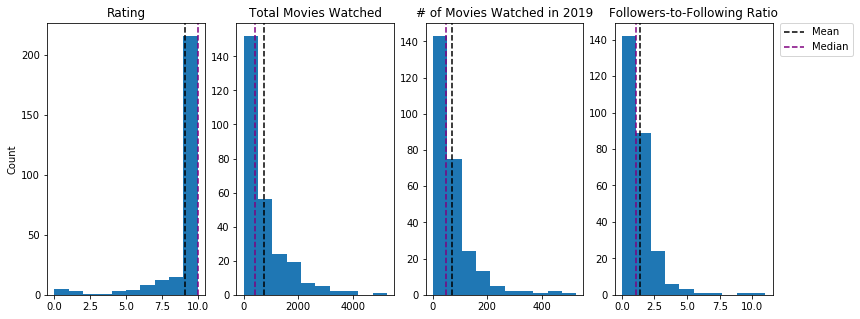

In [49]:
fig, ax = plt.subplots(1, 4, figsize = (13, 5))

# Plotting Shortcut
for i in range(0, 4): 
    plot_dict = {"0" : movie_reviews_short["rating"], "1": movie_reviews_short["total_films"], 
     "2":movie_reviews_short["films_2019"], "3": movie_reviews_short["ratio"]}
    
    ax[i].hist(plot_dict[str(i)])   #using movie_reviews_short since have missing values otherwise
    ax[i].axvline(plot_dict[str(i)].mean(), color='black', linestyle='dashed', linewidth=1.5) 
    ax[i].axvline(plot_dict[str(i)].median(), color='purple', linestyle='dashed', linewidth=1.5) 


# Labels
ax[0].set_ylabel("Count")
ax[0].set_title("Rating")
ax[1].set_title("Total Movies Watched")
ax[2].set_title("# of Movies Watched in 2019")
ax[3].set_title("Followers-to-Following Ratio")

ax[3].legend(["Mean", "Median"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

There seems to be a consensus that Midsommar is quite good. Overall, the average users seems pretty representative, as the mean and median tend to be close.

Is there some kind of skew in the ratings due to individual user characteristics?

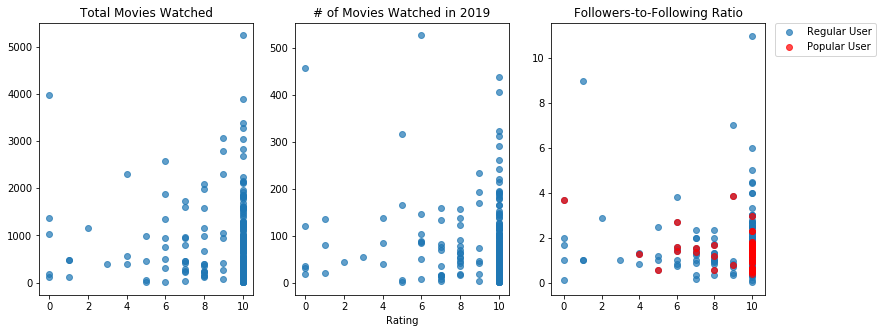

In [95]:
fig, ax = plt.subplots(1, 3, figsize = (13, 5))

# Plotting Shortcut
for i in range(0, 3): 
    plot_dict = {"0" : movie_reviews_short["total_films"], 
     "1":movie_reviews_short["films_2019"], "2": movie_reviews_short["ratio"]}
    
    ax[i].scatter( movie_reviews_short["rating"], plot_dict[str(i)], alpha = 0.7) 
    
    if i == 2:
        ax[i].scatter( movie_reviews_short["rating"][movie_reviews_short["followers"] >= movie_reviews_short["followers"].mean()], 
                  plot_dict[str(i)][movie_reviews_short["followers"] >= movie_reviews_short["followers"].mean()], 
                  alpha = 0.7, color = "red") # adding red points for users w/ above average # of followers
        
        ax[i].legend(["Regular User", "Popular User"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend


# Labels
ax[0].set_title("Total Movies Watched")
ax[1].set_title("# of Movies Watched in 2019")
ax[2].set_title("Followers-to-Following Ratio")
ax[1].set_xlabel("Rating")

plt.show()

Generally it seems that users that watch movies more rated Midsommar higher. The results when it comes to 'popularity' are more muddled. High ratio users tended to rate Midsommar higher, yes, but some of these users have a high ratio because they follow very few people. I therefore colored the datapoints of users with an above-average number of followers in red. Once the total number of followers is taken into account as well, there doesn't seem to be much of a relationship between 'popularity' and rating.

Is there a relationship between the number of movies reviewed and a user's popularity (as proxied by the follower-to-following ratio)?

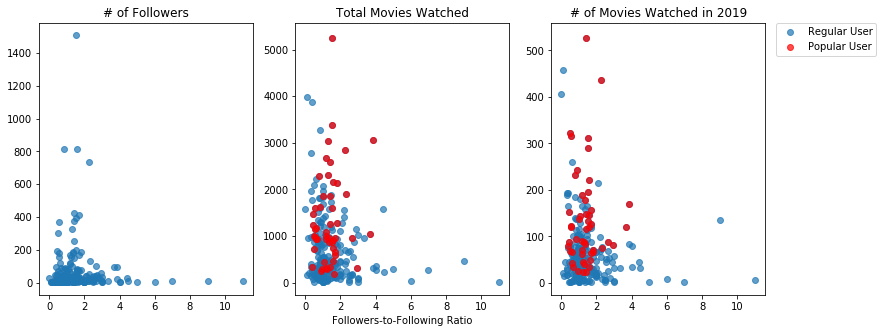

In [96]:
fig, ax = plt.subplots(1, 3, figsize = (13, 5))

# Plotting Shortcut
for i in range(0, 3): 
    plot_dict = {"0" : movie_reviews_short["followers"], "1": movie_reviews_short["total_films"], 
     "2":movie_reviews_short["films_2019"]}
    
    ax[i].scatter( movie_reviews_short["ratio"], plot_dict[str(i)], alpha = 0.7) 
    
    if i >= 1:
        ax[i].scatter( movie_reviews_short["ratio"][movie_reviews_short["followers"] >= movie_reviews_short["followers"].mean()], 
                  plot_dict[str(i)][movie_reviews_short["followers"] >= movie_reviews_short["followers"].mean()], 
                  alpha = 0.7, color = "red") 


# Labels
ax[0].set_title("# of Followers")
ax[1].set_title("Total Movies Watched")
ax[2].set_title("# of Movies Watched in 2019")

ax[2].legend(["Regular User", "Popular User"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax[1].set_xlabel("Followers-to-Following Ratio")

plt.show()

First it is worth noting that (as suspected previously) some users have a high ratio not because they have a high number of followers but because they follow very few people. Again, I color the points of users with an above-average number of followers in red. There seems to be a trend for users that watch more movies to have more followers, but it might help to "zoom into" the 0 - 4 ratio range. 

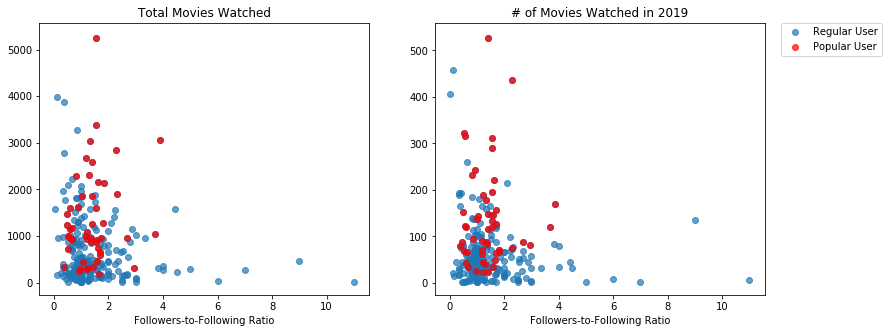

In [98]:
fig, ax = plt.subplots(1, 2, figsize = (13, 5))

# Plotting Shortcut
for i in range(0, 2): 
    plot_dict = {"0": movie_reviews_short["total_films"], 
     "1":movie_reviews_short["films_2019"]}
    
    ax[i].scatter( movie_reviews_short["ratio"], plot_dict[str(i)], alpha = 0.7) 
    
    ax[i].scatter( movie_reviews_short["ratio"][movie_reviews_short["followers"] >= movie_reviews_short["followers"].mean()], 
                  plot_dict[str(i)][movie_reviews_short["followers"] >= movie_reviews_short["followers"].mean()], 
                  alpha = 0.7, color = "red") 
    
    ax[i].set_xlabel("Followers-to-Following Ratio")


# Labels
ax[0].set_title("Total Movies Watched")
ax[1].set_title("# of Movies Watched in 2019")

ax[1].legend(["Regular User", "Popular User"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Do these popular individuals actually influence ratings?

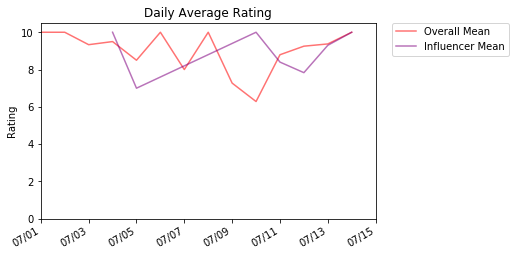

In [105]:
fig, ax = plt.subplots()

ax.plot(movie_reviews_short.groupby('date')['rating'].mean().index, 
           movie_reviews_short.groupby('date')['rating'].mean(), alpha = 0.55,
          color = "red") 

ax.plot(movie_reviews_short[(movie_reviews_short["ratio"] > movie_reviews_short["ratio"].quantile(0.65)) & 
                                  (movie_reviews_short["followers"] >= movie_reviews_short["followers"].mean())].groupby('date')['rating'].mean().index, 
           movie_reviews_short[(movie_reviews_short["ratio"] > movie_reviews_short["ratio"].quantile(0.65)) & 
                                  (movie_reviews_short["followers"] >= movie_reviews_short["followers"].mean())].groupby('date')['rating'].mean(), alpha = 0.55,
          color = "purple") 

#axis labels
ax.set_ylabel("Rating")
ax.set_title("Daily Average Rating")
ax.set_ylim([0, 10.5])
ax.set_xlim(["2019/07/01", "2019/07/15"])

#adding legend
plt.legend(["Overall Mean", "Influencer Mean"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#date formatting
fig.autofmt_xdate() #rotating axis for legibility
ax.xaxis.set_major_formatter(DateFormatter('%m/%d')) #displaying months only for legibility

plt.show(); 

The graph is, at best, inconclusive.

I now look at some facts about the ratings.

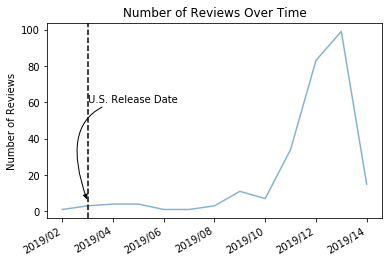

In [106]:
fig, ax = plt.subplots()
ax.plot(movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].count().index, 
           movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].count(), alpha = 0.55) 

plt.axvline("2019/07/03", color='black', linestyle='dashed', linewidth=1.5) #release date

#axis labels
ax.set_ylabel("Number of Reviews")
ax.set_title("Number of Reviews Over Time")

#adding annotation
plt.annotate('U.S. Release Date', xy=("2019/07/03", 5.5), xytext=("2019/07/03", 60), fontsize=10,
arrowprops=dict(arrowstyle= "-|>", connectionstyle= "angle3,angleA=5,angleB=110", facecolor='black')
)

fig.autofmt_xdate() #rotating axis for legibility
ax.xaxis.set_major_formatter(DateFormatter('%Y/%d')) #displaying months only for legibility
plt.show(); 

The movie came out on July 3 2019 but reviews only started to increase during the July 12-14 week-end. (The data collection occured on July 14, hence the dip in reviews on that day).

The ratings have been fairly consistently positive.

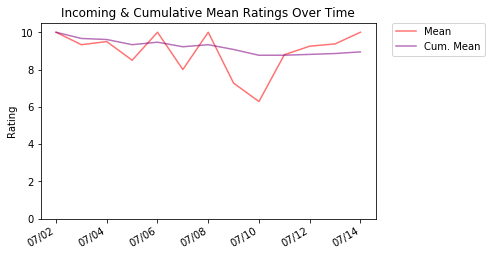

In [107]:
fig, ax = plt.subplots()

ax.plot(movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean().index, 
           movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean(), alpha = 0.55,
          color = "red") 

ax.plot(movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean().index, 
           movie_reviews_short[movie_reviews_short["date"] > "2019/07/01"].groupby('date')['rating'].mean().expanding().mean(), 
        alpha = 0.55, color = "purple")

#axis labels
ax.set_ylabel("Rating")
ax.set_title("Incoming & Cumulative Mean Ratings Over Time")
ax.set_ylim([0, 10.5])

#adding legend
plt.legend(["Mean", "Cum. Mean"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#date formatting
fig.autofmt_xdate() #rotating axis for legibility
ax.xaxis.set_major_formatter(DateFormatter('%m/%d')) #displaying months only for legibility

plt.show(); 

### Saving the dataframes

Scraping the data can be something of a hassle, so I save all of the information I collected into excel and csv files.

In [109]:
movie_reviews.to_excel('movie_reviews_midsommar.xlsx', sheet_name='sheet1', index=False)
letterboxd_network.to_excel('letterboxd_network.xlsx', sheet_name='sheet1', index=False)

In [111]:
movie_reviews.to_csv('movie_reviews_midsommar.csv', index=False)
letterboxd_network.to_csv('letterboxd_network.csv', index=False)